In [18]:
from google.colab import drive, output
drive.mount('/content/drive')
import sys
%cd '/content/drive/MyDrive/Deep Learning/AutoEncoders/Project'
sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/Dataloader')
sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/Models')
%load_ext autoreload
%autoreload 2
!pip install torchaudio
!pip install wandb --upgrade
!wandb login
output.clear()

In [19]:
from __future__ import print_function
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

#import umap
#import wandb
import torch
import pandas as pd

from scipy import signal
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

#from ResidualStack import ResidualStack

from Models import Model
from Dataloader import EcoData


from Models import Encoder

from Models import Decoder

from Residual import Residual

from Models import VectorQuantizer
from Models import VectorQuantizerEMA


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

cuda


## Train

We use the hyperparameters from the author's code:

In [5]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos'
labels_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Acceso_Datos_Humboldt/ensayo.xlsx'
names_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Acceso_Datos_Humboldt/RecordingsGuajiraTesisWeights.xlsx'



batch_size = 1
num_training_updates = 100

num_hiddens = 32
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 128
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

num_epochs = 200

learning_rate = 1e-3

dataset = EcoData(root_path, labels_path, names_path, 60, "wav")
training_loader = DataLoader(dataset, batch_size=batch_size)

In [7]:
model = Model(num_hiddens, num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

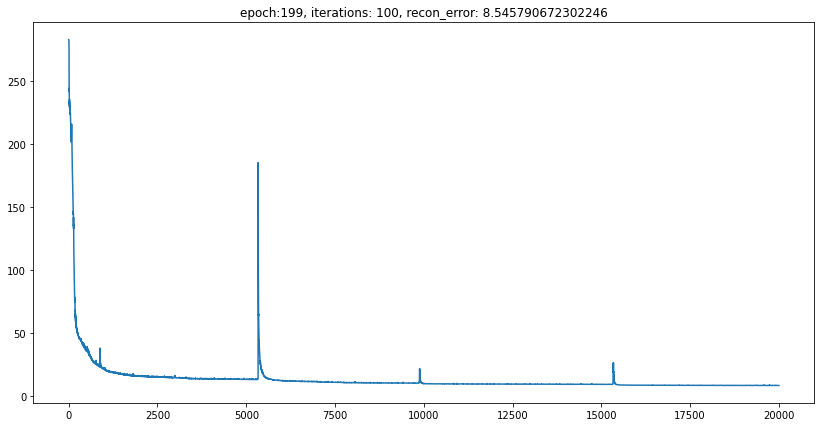

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []


for epoch in range(num_epochs):
  for i in xrange(num_training_updates):
      (data, _,_,_) = next(iter(training_loader))
      #print(i)
      data = torch.reshape(data, (data.shape[0] * data.shape[1], data.shape[2], data.shape[3]))
      data = torch.unsqueeze(data,1)
      data = data.to(device)
      
      
      optimizer.zero_grad()
      vq_loss, data_recon, perplexity = model(data)
      
      recon_error = F.mse_loss(data_recon, data[:,:,:data_recon.shape[2],:data_recon.shape[3]]) #/ data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()

      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())

      if (i+1) % 20 == 0:
        output.clear()
        plt.figure(figsize=(14,7))
        plt.plot(train_res_recon_error)
        plt.title(f'epoch:{epoch}, iterations: {(i+1)}, recon_error: {train_res_recon_error[-1]}')
        plt.show()
      if (i+1) % 1000 == 0:
        torch.save(model.state_dict(),'model7.pkl')
      
  if (epoch+1) % 10 == 0:
    torch.save(model.state_dict(),'model_2_epoch_'+str(epoch)+'.pkl')


In [8]:
model.load_state_dict(torch.load('model_2_epoch_9.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

## Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [9]:
model.eval()
validation_loader = training_loader
(valid_originals, _,_,_) = next(iter(validation_loader),30000)

## View Reconstructions

In [10]:
model.eval()
validation_loader = training_loader
(valid_originals, _,_,_) = next(iter(validation_loader),30000)
valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], valid_originals.shape[2], valid_originals.shape[3]))
valid_originals = torch.unsqueeze(valid_originals,1)

print(valid_originals.shape)



valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

torch.Size([5, 1, 1025, 2813])


In [12]:
def showTensor(tensor, dim):
    return tensor[dim,:,:,:].cpu().detach().numpy()[0,:,:]

In [13]:
plt.figure(figsize=(40,40))

plt.subplot(5,2,1)
plt.imshow(showTensor(valid_originals,0),vmin=0,vmax=0.7)
plt.subplot(5,2,2)
plt.imshow(showTensor(valid_reconstructions,0),vmin=0,vmax=0.7)
plt.subplot(5,2,3)
plt.imshow(showTensor(valid_originals,1),vmin=0,vmax=0.7)
plt.subplot(5,2,4)
plt.imshow(showTensor(valid_reconstructions,1),vmin=0,vmax=0.7)
plt.subplot(5,2,5)
plt.imshow(showTensor(valid_originals,2),vmin=0,vmax=0.7)
plt.subplot(5,2,6)
plt.imshow(showTensor(valid_reconstructions,2),vmin=0,vmax=0.7)
plt.subplot(5,2,7)
plt.imshow(showTensor(valid_originals,3),vmin=0,vmax=0.7)
plt.subplot(5,2,8)
plt.imshow(showTensor(valid_reconstructions,3),vmin=0,vmax=0.7)
plt.subplot(5,2,9)
plt.imshow(showTensor(valid_originals,4),vmin=0,vmax=0.7)
plt.subplot(5,2,10)
plt.imshow(showTensor(valid_reconstructions,4),vmin=0,vmax=0.7)
#plt.savefig("VQVAE_Sin_Residual.pdf")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
(train_originals, _,_,_) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

In [ ]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)